<a href="https://colab.research.google.com/github/griffinfulton-uark/Classification-Model-Project-/blob/main/ClassificationModelExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## In this File we looked at some of the methods for classifying our data. We ended up decided on BERT, this is in the ClassificationModel.ipynb

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install snscrape
!pip install transformers
!pip install lime

In [ ]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text
## for word embedding
import gensim
import gensim.downloader as gensim_api
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
## for bert language model
import transformers

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Preprocessing

In [ ]:
# read platform tweets
platform_tweets = pd.read_csv('/content/drive/MyDrive/EconomicAnalyticsFinalProject/platform_tweets.csv')

In [ ]:
def get_party(x):
  if x == 'GOP' or x == 'GOPChairwoman':
    return 'R'
  else: 
    return 'D'
  
platform_tweets['OutcomeVar'] = platform_tweets['User'].apply(lambda x: get_party(x))

In [ ]:
platform_tweets.sample(10)

,Unnamed: 0,Date,User,Tweets,handle,Party,OutcomeVar
9110,2944,2021-03-16 21:57:01+00:00,TheDemocrats,Here’s a huge sign we’re not going to let Joni...,"['GOP', 'R']","['GOPChairwoman', 'R']",D
1972,1972,2021-10-02 17:09:06+00:00,GOP,The RNC is excited to continue to expand our m...,"['GOP', 'R']","['GOPChairwoman', 'R']",R
12588,2860,2021-03-06 15:17:13+00:00,harrisonjaime,Amen @SenSherrodBrown ! https://t.co/Ox7uKlp8m1,"['GOP', 'R']","['GOPChairwoman', 'R']",D
169,169,2022-04-02 19:28:00+00:00,GOP,"First it was Twitter, now YouTube.\n \nIf big ...","['GOP', 'R']","['GOPChairwoman', 'R']",R
1231,1231,2021-12-31 15:54:45+00:00,GOP,Happy New Year’s Eve!,"['GOP', 'R']","['GOPChairwoman', 'R']",R
9773,45,2022-04-04 18:07:27+00:00,harrisonjaime,@255lori Check your phone because it is broken...,"['GOP', 'R']","['GOPChairwoman', 'R']",D
4894,1809,2021-08-03 12:41:06+00:00,GOPChairwoman,Tune in now to a NEW episode of my podcast #Re...,"['GOP', 'R']","['GOPChairwoman', 'R']",R
2874,2874,2021-03-17 19:47:05+00:00,GOP,"""The American people do not want a Washington ...","['GOP', 'R']","['GOPChairwoman', 'R']",R
815,815,2022-02-08 01:38:00+00:00,GOP,Joe Biden has given Chinese president Xi Jinpi...,"['GOP', 'R']","['GOPChairwoman', 'R']",R
1370,1370,2021-12-15 11:27:00+00:00,GOP,"Month after month, Bidenflation increases.\n \...","['GOP', 'R']","['GOPChairwoman', 'R']",R


## Data Exploration

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

def plot_simple(x, y, model_data):
  fig, ax = plt.subplots(nrows=1, ncols=2)
  fig.suptitle(x, fontsize=12)
  for i in model_data[y].unique():
      sns.distplot(model_data[model_data[y]==i][x], hist=True, kde=False, 
                  bins=10, hist_kws={"alpha":0.8}, 
                  axlabel="histogram", ax=ax[0])
      sns.distplot(model_data[model_data[y]==i][x], hist=False, kde=True, 
                  kde_kws={"shade":True}, axlabel="density",   
                  ax=ax[1])
  ax[0].grid(True)
  ax[0].legend(model_data[y].unique())
  ax[1].grid(True)
  plt.show()

lst_stopwords = nltk.corpus.stopwords.words("english")

platform_tweets["tweets_clean"] = platform_tweets["Tweets"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
platform_tweets.head()

In [ ]:
explore = platform_tweets[['OutcomeVar', 'Tweets', 'tweets_clean']]

In [ ]:
explore.sample(10)

,OutcomeVar,Tweets
8583,D,.@POTUS is right: “This is our moment to rebui...
3940,R,My heart goes out to the students of Oxford Hi...
10502,D,Stay safe folks! Scary stuff! https://t.co/qX...
6223,D,The Biden-Harris administration is helping Ame...
3470,R,The RNC is suing the Bucks County Board of Ele...
10099,D,"Given the Trump White House, this is the tip o..."
680,R,The evidence indicates #Bidenflation is only g...
3172,R,The media blindly repeated the outright lie th...
3372,R,Biden is so serious about securing the border ...
11725,D,https://t.co/zlLNAHTctN https://t.co/zGACmUgbJq


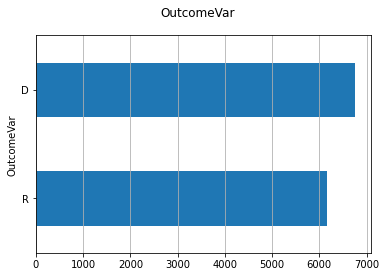

In [ ]:
plot_distributions(explore, x="OutcomeVar", top=None, figsize=(7,3))

In [ ]:
model_data['word_count'] = model_data["Tweets"].apply(lambda x: len(str(x).split(" ")))
model_data['char_count'] = model_data["Tweets"].apply(lambda x: sum(len(word) for word in str(x).split(" ")))
model_data['sentence_count'] = model_data["Tweets"].apply(lambda x: len(str(x).split(".")))
model_data['avg_word_length'] = model_data['char_count'] / model_data['word_count']
model_data['avg_sentence_lenght'] = model_data['word_count'] / model_data['sentence_count']
model_data["sentiment"] = model_data['Tweets'].apply(lambda x: 
                   TextBlob(x).sentiment.polarity)
model_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,OutcomeVar,tweets_clean,Tweets,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght
0,R,march encounter passed previous biden peak set...,March’s encounters passed the previous Biden p...,20,111,2,5.550000,10.0
1,R,johnjamesmi gopchairwoman american tired biden...,@JohnJamesMI @GOPChairwoman Americans are tire...,8,62,1,7.750000,8.0
2,R,gopchairwoman johnjamesmi know bidengashike im...,.@GOPChairwoman and @JohnJamesMI know how the ...,18,142,4,7.888889,4.5
3,R,juliafriedland affordable better httpstcocbcfr...,@JuliaFriedland When ours are more affordable ...,9,74,3,8.222222,3.0
4,R,rise black conservative breaking left wesleyhu...,🚨The rise of Black conservatives is breaking t...,37,218,2,5.891892,18.5


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

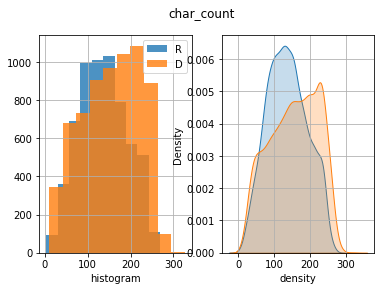

In [ ]:
plot_simple()

,OutcomeVar,tweets_clean,Tweets,word_count,char_count,sentence_count,avg_word_length,avg_sentence_lenght,sentiment
0,R,march encounter passed previous biden peak set...,March’s encounters passed the previous Biden p...,20,111,2,5.550000,10.0,-0.208333
1,R,johnjamesmi gopchairwoman american tired biden...,@JohnJamesMI @GOPChairwoman Americans are tire...,8,62,1,7.750000,8.0,-0.500000
2,R,gopchairwoman johnjamesmi know bidengashike im...,.@GOPChairwoman and @JohnJamesMI know how the ...,18,142,4,7.888889,4.5,0.000000
3,R,juliafriedland affordable better httpstcocbcfr...,@JuliaFriedland When ours are more affordable ...,9,74,3,8.222222,3.0,0.500000
4,R,rise black conservative breaking left wesleyhu...,🚨The rise of Black conservatives is breaking t...,37,218,2,5.891892,18.5,-0.174306


## Data Preprocessing cont.

In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

lst_stopwords = nltk.corpus.stopwords.words("english")

platform_tweets["tweets_clean"] = platform_tweets["Tweets"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
platform_tweets.head()

,Unnamed: 0,Date,User,Tweets,handle,Party,OutcomeVar,tweets_clean
0,0,2022-04-19 23:39:00+00:00,GOP,March’s encounters passed the previous Biden p...,"['GOP', 'R']","['GOPChairwoman', 'R']",R,march encounter passed previous biden peak set...
1,1,2022-04-19 22:35:16+00:00,GOP,@JohnJamesMI @GOPChairwoman Americans are tire...,"['GOP', 'R']","['GOPChairwoman', 'R']",R,johnjamesmi gopchairwoman american tired biden...
2,2,2022-04-19 21:22:00+00:00,GOP,.@GOPChairwoman and @JohnJamesMI know how the ...,"['GOP', 'R']","['GOPChairwoman', 'R']",R,gopchairwoman johnjamesmi know bidengashike im...
3,3,2022-04-19 20:46:13+00:00,GOP,@JuliaFriedland When ours are more affordable ...,"['GOP', 'R']","['GOPChairwoman', 'R']",R,juliafriedland affordable better httpstcocbcfr...
4,4,2022-04-19 19:53:01+00:00,GOP,🚨The rise of Black conservatives is breaking t...,"['GOP', 'R']","['GOPChairwoman', 'R']",R,rise black conservative breaking left wesleyhu...


In [ ]:
model_data = platform_tweets[['OutcomeVar', 'tweets_clean', 'Tweets']]
model_data.sample(10)

,OutcomeVar,tweets_clean,Tweets
3365,R,bidens sotu made misplaced priority clear ment...,Biden’s #SOTU made his misplaced priorities cl...
7545,D,thanks president joebidens american rescue pla...,Thanks to President @JoeBiden's American Rescu...
9614,D,new american story begin today inaugurationday...,A new American story begins today. #Inaugurati...
3806,R,biden border czar harris never going comment w...,So are Biden and “Border Czar” Harris just nev...
5466,R,seriously harris taking border crisis cant eve...,How seriously is Harris taking the border cris...
844,R,due joe bidens failed economy super bowl food ...,Due to Joe Biden’s failed economy Super Bowl f...
3865,R,cbo found bidens build back broke act would in...,The CBO just found that Biden’s Build Back Bro...
5427,R,given revelation biden administration expect b...,Given this revelation from the Biden administr...
10305,D,one year bidenharris administration taking tim...,We’re one year into the Biden-Harris administr...
6138,R,heartbroken loss life capitol police community...,Heartbroken at the loss of life in the Capitol...


In [ ]:
model_data.shape

(12918, 3)

In [ ]:
## split dataset
model_train, model_test = model_selection.train_test_split(model_data, test_size=0.2)
## get target
y_train = model_train["OutcomeVar"].values
y_test = model_test["OutcomeVar"].values

In [ ]:
y_test.shape

(2584,)

## Useful Functions

In [ ]:
def plot_distributions(dtf, x, top=None, figsize=(7,3)):
  fig, ax = plt.subplots()
  fig.suptitle(x, fontsize=12)
  dtf[x].reset_index().groupby(x).count().sort_values(by= 
        "index").plot(kind="barh", legend=False, 
          ax=ax).grid(axis='x')
  plt.show()

In [ ]:
from sklearn import metrics as metric

def evaluate_multi_classif(y_test, predicted, predicted_prob, figsize):
  classes = np.unique(y_test)
  y_test_array = pd.get_dummies(y_test, drop_first=False).values
  print(y_test.shape)
  print(y_test_array.shape)
  print(predicted_prob.shape)

  ## Accuracy, Precision, Recall
  accuracy = metric.accuracy_score(y_test, predicted)
  #auc = metric.roc_auc_score(y_test_array, predicted_prob, multi_class="ovr")
  print("Accuracy:",  round(accuracy,2))
  #print("Auc:", round(auc,2))
  print("Detail:")
  print(metric.classification_report(y_test, predicted))
      
  ## Plot confusion matrix
  cm = metric.confusion_matrix(y_test, predicted)
  fig, ax = plt.subplots()
  sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
              cbar=False)
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)

  fig, ax = plt.subplots(nrows=1, ncols=2)
  ## Plot roc
  for i in range(len(classes)):
      fpr, tpr, thresholds = metric.roc_curve(y_test_array[:,i],  
                            predicted_prob[:,i])
      ax[0].plot(fpr, tpr, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                metric.auc(fpr, tpr))
                )
  ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
  ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
            xlabel='False Positive Rate', 
            ylabel="True Positive Rate (Recall)", 
            title="Receiver operating characteristic")
  ax[0].legend(loc="lower right")
  ax[0].grid(True)
      
  ## Plot precision-recall curve
  for i in range(len(classes)):
      precision, recall, thresholds = metric.precision_recall_curve(
                  y_test_array[:,i], predicted_prob[:,i])
      ax[1].plot(recall, precision, lw=3, 
                label='{0} (area={1:0.2f})'.format(classes[i], 
                                    metric.auc(recall, precision))
                )
  ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
            ylabel="Precision", title="Precision-Recall curve")
  ax[1].legend(loc="best")
  ax[1].grid(True)
  plt.show()

## Bag-Of-Words (Term-Frequency)

In [ ]:
## Tf-Idf (advanced variant of BoW)
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=115000, ngram_range=(1,2))

In [ ]:
corpus = model_train["tweets_clean"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [ ]:
X_train.shape

(10334, 112994)

Text(0.5, 1.0, 'Sparse Matrix Sample')

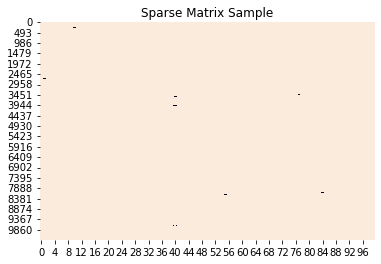

In [ ]:
sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

In [ ]:
word = "biden"
dic_vocabulary[word]

12135

In [ ]:
from sklearn import feature_selection

y = model_train["OutcomeVar"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "y":cat}))
    dtf_features = dtf_features.sort_values(["y","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["y"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["y"]==cat]["feature"].values[:10]))
   print(" ")

# D:
  . selected features: 468
  . top features: biden,border,joe,joe biden,bidens,policy,price,border crisis,failed,joe bidens
 
# R:
  . selected features: 468
  . top features: biden,border,joe,joe biden,bidens,policy,price,border crisis,failed,joe bidens
 


In [ ]:
vectorizer = feature_extraction.text.TfidfVectorizer(vocabulary=X_names)
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_


In [ ]:
X_train.shape

(10334, 468)

In [ ]:
#bayesian classifier option

#classifier = naive_bayes.MultinomialNB()


## pipeline
model = pipeline.Pipeline([("vectorizer", vectorizer),  
                           ("classifier", classifier)])
## train classifier
model["classifier"].fit(X_train, y_train)
## test
X_test = model_test["tweets_clean"].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

NameError: ignored

In [ ]:
y.shape

(10334,)

## Term Frequency Results

Accuracy: 0.88
Auc: 0.95
Detail:
              precision    recall  f1-score   support

           D       0.85      0.94      0.89      1339
           R       0.92      0.82      0.87      1245

    accuracy                           0.88      2584
   macro avg       0.89      0.88      0.88      2584
weighted avg       0.89      0.88      0.88      2584



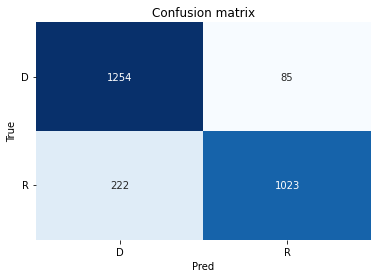

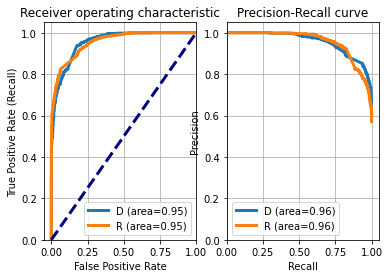

In [ ]:
from sklearn import metrics

classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test_array, predicted_prob, multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

## Word Embeddings


In [ ]:
nlp = gensim_api.load("glove-twitter-200")

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
corpus = model_train["tweets_clean"]

## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)

## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [ ]:
## fit w2v
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   window=8, min_count=1, sg=1, iter=30)

In [ ]:
word = "joe"
nlp[word].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


(300,)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentat

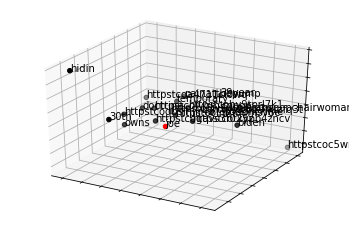

In [ ]:
word = "joe"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 nlp.most_similar(word, topn=20)]
X = nlp[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

In [ ]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
## create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

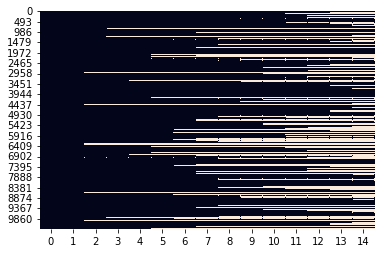

In [ ]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [ ]:
i = 0

## list of text: ["I like this", ...]
len_txt = len(model_train["tweets_clean"].iloc[i].split())
print("from: ", model_train["tweets_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", model_train["tweets_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[model_train["tweets_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  israel attack democrat rep rashida tlaib renewing call antisemitic bd movement joe biden need condemn radical rhetoric reaffirm u stand israel one greatest ally | len: 24
to:  [ 984  304    4 1012 2872 2607 2873  135 1542 3199  919   10    3   21
  920] | len: 15
check:  israel  -- idx in vocabulary --> 984
vocabulary:  {'NaN': 1, 'american': 2, 'biden': 3, 'democrat': 4, 'republican': 5} ... (padding element, 0)


In [ ]:
corpus = model_test["tweets_clean"]

## create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
## detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
## text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

## padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [ ]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
word = "joe"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 10 |idx
embeddings[idx]: (300,) |vector


In [ ]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x

## input
x_in = layers.Input(shape=(15,))
## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)
## apply attention
x = attention_layer(x, neurons=15)
## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)
## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)
## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 300)      5384700     ['input_1[0][0]']                
                                                                                                  
 permute (Permute)              (None, 300, 15)      0           ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 300, 15)      240         ['permute[0][0]']                
                                                                                              

## Word Embeddings Results

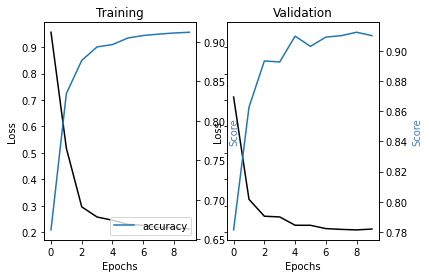

In [ ]:
## encode y
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])
## train
training = model.fit(x=X_train, y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=0.3)
## plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

(2584,)
(2584, 2)
(2584, 3)
Accuracy: 0.84
Detail:
              precision    recall  f1-score   support

           D       0.78      0.95      0.86      1339
           R       0.93      0.71      0.81      1245

    accuracy                           0.84      2584
   macro avg       0.86      0.83      0.83      2584
weighted avg       0.86      0.84      0.83      2584



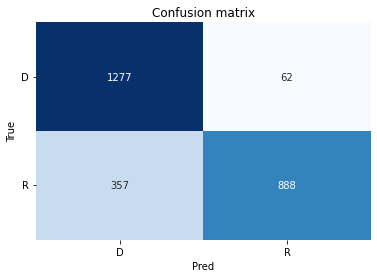

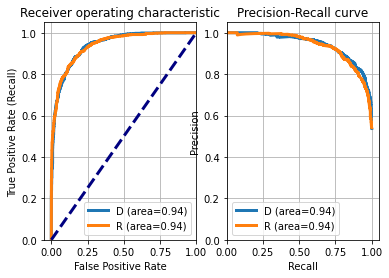

In [ ]:


## test
predicted_prob = model.predict(X_test)
predicted = [dic_y_mapping[np.argmax(pred)] for pred in 
             predicted_prob]

evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5))

# References

## https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794